In [1]:
import matplotlib.animation as animation
import math
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

from specutils import Spectrum1D, SpectralRegion
import scipy.ndimage as ndimage
import os
import moviepy.video.io.ImageSequenceClip
from scipy.signal import convolve2d
from scipy.ndimage import center_of_mass, shift
from scipy.ndimage import sobel
import matplotlib as mpl
import imageio
import os
from tqdm import tqdm

from astropy.stats import sigma_clip
import time as time
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
%matplotlib inline
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
mpl.rcParams['figure.figsize'] = (10.0, 10.0)     # set figure size
mpl.rcParams['font.family'] = 'Serif'      # set font
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.size'] = 17
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['xtick.top'] = True  
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.major.size'] = 18
mpl.rcParams['xtick.major.pad'] = 14
mpl.rcParams['ytick.major.pad'] = 14

mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.minor.size'] = 10
mpl.rcParams['ytick.major.size'] = 18
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.minor.size'] = 10
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
from scipy.ndimage import gaussian_filter
from astropy.convolution import convolve, Box2DKernel
from astropy.convolution import convolve, Gaussian1DKernel, Gaussian2DKernel, Box1DKernel
from astropy.io import fits
from scipy.constants import c
#import twochanneldeconv


from pylab import *
from matplotlib import rcParams, colors

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DeprecationWarning)
    # your call to interp2d
warnings.filterwarnings('ignore')
#------------#
######### SAURON COLORMAP ##############
#
# Original format:
#x = [1.0, 43.5, 86.0, 86.0+20, 128.5-10, 128.5, 128.5+10, 171.0-20, 171.0, 213.5, 256.0]
#red =   [0.01, 0.0, 0.4,  0.5, 0.3, 0.0, 0.7, 1.0, 1.0,  1.0, 0.9]
#green = [0.01, 0.0, 0.85, 1.0, 1.0, 0.9, 1.0, 1.0, 0.85, 0.0, 0.9]
#blue =  [0.01, 1.0, 1.0,  1.0, 0.7, 0.0, 0.0, 0.0, 0.0,  0.0, 0.9]

_sauron_data = {
    'red': ((0.0,0.01,0.01),
            (0.169921875,0.0,0.0),
            (0.3359375,0.4,0.4),
            (0.4140625,0.5,0.5),
            (0.462890625,0.3,0.3),
            (0.501953125,0.0,0.0),
            (0.541015625,0.7,0.7),
            (0.58984375,1.0,1.0),
            (0.66796875,1.0,1.0),
            (0.833984375,1.0,1.0),
            (1.0,0.9,0.9)),
    'green':((0.0,0.01,0.01),
             (0.169921875,0.0,0.0),
             (0.3359375,0.85,0.85),
             (0.4140625,1.0,1.0),
             (0.462890625,1.0,1.0),
             (0.501953125,0.9,0.9),
             (0.541015625,1.0,1.0),
             (0.58984375,1.0,1.0),
             (0.66796875,0.85,0.85),
             (0.833984375,0.0,0.0),
             (1.0,0.9,0.9)),
    'blue':((0.0,0.01,0.01),
            (0.169921875,1.0,1.0),
            (0.3359375,1.0,1.0),
            (0.4140625,1.0,1.0),
            (0.462890625,0.7,0.7),
            (0.501953125,0.0,0.0),
            (0.541015625,0.0,0.0),
            (0.58984375,0.0,0.0),
            (0.66796875,0.0,0.0),
            (0.833984375,0.0,0.0),
            (1.0,0.9,0.9))
    }
_sauron_inv_data = {
    'red': ((0.0,1.0,1.0),
            (0.169921875,1.0,1.0),
            (0.3359375,1.0,1.0),
            (0.4140625,0.4,0.4),
            (0.462890625,0.7,0.7),
            (0.501953125,0.0,0.0),
            (0.541015625,0.3,0.3),
            (0.58984375,0.5,0.5),
            (0.66796875,0.0,0.0),
            (0.833984375,1.0,1.0),
            (1.0,0.01,0.01)),
    'green':((0.0,1.0,1.0),
             (0.169921875,0.0,0.0),
             (0.3359375,0.85,0.85),
             (0.4140625,1.0,1.0),
             (0.462890625,1.0,1.0),
             (0.501953125,0.9,0.9),
             (0.541015625,1.0,1.0),
             (0.58984375,1.0,1.0),
             (0.66796875,0.85,0.85),
             (0.833984375,0.0,0.0),
             (1.0,0.01,0.01)),
    'blue':((0.0,1.0,1.0),
            (0.169921875,0.0,0.0),
            (0.3359375,0.0,0.0),
            (0.4140625,0.0,0.0),
            (0.462890625,0.0,0.0),
            (0.501953125,0.0,0.0),
            (0.541015625,0.7,0.7),
            (0.58984375,1.0,1.0),
            (0.66796875,1.0,1.0),
            (0.833984375,1.0,1.0),
            (1.0,0.01,0.01))
    }

sauron=colors.LinearSegmentedColormap('sauron', _sauron_data)
sauron_inv=colors.LinearSegmentedColormap('sauron_inv', _sauron_inv_data)
register_cmap(cmap=sauron)
register_cmap(cmap=sauron_inv)
rcParams['image.cmap']='sauron'

cmap = plt.cm.get_cmap("sauron")
cmap.set_bad('w',1.)

from scipy.ndimage import shift


/var/folders/kc/f6dvl8r953l667w3g26bw_s09jrsqf/T/ipykernel_10976/1872515420.py:24: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,


In [3]:
from cubecarve.pipeline import CubeCarve
from cubecarve.utils.arrays import myconvolve


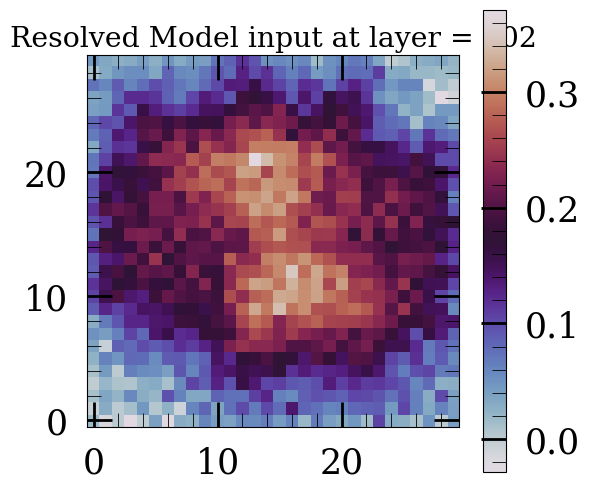

In [4]:

def gaussian(x, mu, sig):
    """
    Calculates the 1D Gaussian probability density function (PDF).
    
    Args:
        x (numpy.array): The x-values at which to evaluate the PDF.
        mu (float): The mean (center) of the distribution.
        sig (float): The standard deviation (width) of the distribution.
        
    Returns:
        numpy.array: The corresponding y-values of the Gaussian curve.
    """
    # The formula for the normal distribution PDF
    return (1.0 / (np.sqrt(2.0 * np.pi) * sig) * 
            np.exp(-np.power((x - mu) / sig, 2.0) / 2))


# -----------------------------
# Image grid
# -----------------------------
nz, ny, nx = 1000, 30, 30
line_mask = gaussian(np.arange(0,nz),200,5)
cube = np.zeros((nz,nx,ny))
cube_resolved = np.zeros((nz,nx,ny))
MEAN = 0.0           # The mean (center) of the noise distribution
STD_DEV = 0.02      # The standard deviation (spread) of the noise
ARRAY_SHAPE = (30, 30) # The desired dimensions (height, width) of the 2D array

# --- Generate the 2D Gaussian noise model ---
# The np.random.normal function takes mean, standard deviation, and shape as inputs.
gaussian_noise_2d = np.random.normal(MEAN, STD_DEV, ARRAY_SHAPE)

for i in range(nz):
    y, x = np.indices((ny, nx))

    # Center of the structure
    x0, y0 = nx // 2, ny // 2

    # Elliptical scaling (controls ellipticity)
    a = 2      # x-axis scaling
    b = 1.0      # y-axis scaling

    # Shifted coordinates
    xp = (x - x0) / a
    yp = (y - y0) / b

    # Elliptical radius and angle
    r = np.sqrt(xp**2 + yp**2)
    theta = np.arctan2(yp, xp)

    # -----------------------------
    # Low-frequency edge modulation
    # -----------------------------
    # Controls the waviness of the ellipse boundary
    wave_amp = 0.2        # strength of the edge perturbation
    wave_mode = 15         # number of lobes (low-frequency)
    r_edge = 10.0          # characteristic radius of the ellipse

    r_mod = r_edge * (1 + wave_amp * np.cos(wave_mode * theta))

    # -----------------------------
    # Radial brightness profile
    # -----------------------------
    # Bright inside, fading outward
    sigma = 18.0
    radial_profile = np.exp(-0.5 * (r / sigma)**2)

    # Soft edge using a logistic transition
    edge_width = 1.0
    edge_mask = 1.0 / (1.0 + np.exp((r - r_mod) / edge_width))

    kernel = Gaussian2DKernel(1.5).array

    # Final image
    image = radial_profile * edge_mask * line_mask[i] * 3

    ##### Cone Emission Add On

    ny, nx = 30, 30
    y, x = np.indices((ny, nx))

    # Center of the image
    x0, y0 = nx // 2, ny // 2
    dx = x - x0
    dy = y - y0

    # -----------------------------
    # Position angle (degrees)
    # -----------------------------
    PA_deg = 104.0            # change this to rotate the cones
    PA = np.deg2rad(PA_deg)

    # Rotate coordinates
    x_rot = dx * np.cos(PA) + dy * np.sin(PA)
    y_rot = -dx * np.sin(PA) + dy * np.cos(PA)

    # -----------------------------
    # Bi-conical geometry
    # -----------------------------
    opening_angle = np.deg2rad(50.0)   # half-opening angle of each cone

    r = np.sqrt(x_rot**2 + y_rot**2)

    # Angle away from cone axis (absolute gives two opposite cones)
    theta = np.arctan2(np.abs(y_rot), np.abs(x_rot))

    # Cone mask
    cone_mask = theta < opening_angle

    # -----------------------------
    # Radial brightness profile
    # -----------------------------
    # Suppress very center + fade outward
    r_inner = 1.0
    r_scale = 20.0

    radial_profile = np.exp(-r / r_scale) * (1.0 - np.exp(-r / r_inner))

    # -----------------------------
    # Soft angular edges
    # -----------------------------
    angular_soft = np.exp(-0.5 * (theta / opening_angle)**4)

    # -----------------------------
    # Final image
    # -----------------------------
    image += cone_mask * radial_profile * angular_soft * line_mask[i] * 2

    # print(np.shape(image))
    # print(np.shape(kernel))
    

    if(i == 202):
        plt.figure(figsize=(6,6))
        plt.title('Resolved Model input at layer = 202')
        plt.imshow(myconvolve(image,kernel) + gaussian_noise_2d, cmap='twilight',origin='lower')
        plt.colorbar()
        plt.show()
    cube_resolved[i] = myconvolve(image,kernel) + gaussian_noise_2d
    image[20,19] += 40
    image[9,12] += 25
    image = myconvolve(image,kernel)
    image += gaussian_noise_2d

    cube[i] = image

    # print(np.max(image))

    
    
# -----------------------------
# Display
# -----------------------------
# plt.figure(figsize=(6, 6))





In [4]:
deactivate = np.array([])
deactivate = np.arange(180,220,1)
pointsources = np.zeros_like(cube[0])
# Declare/Guess the Positions of Point Sources in your Image/Cube
# CubeCarve will build Model PSF based on those positions
pointsources[20,19] = 1 # 29 for 1399-1400
pointsources[9,12] = 1 # 29 for 1399-1400


CC = CubeCarve(cube,6,pointsources,xpixelsize=1,ypixelsize=1)

In [5]:
# make psf cube
index = np.array([203])
CC.build_psf_cube(deactivate,200,4,4,index)

Empirical PSF Model(s) Built
Ready to run


In [6]:
CC.run(800,6)

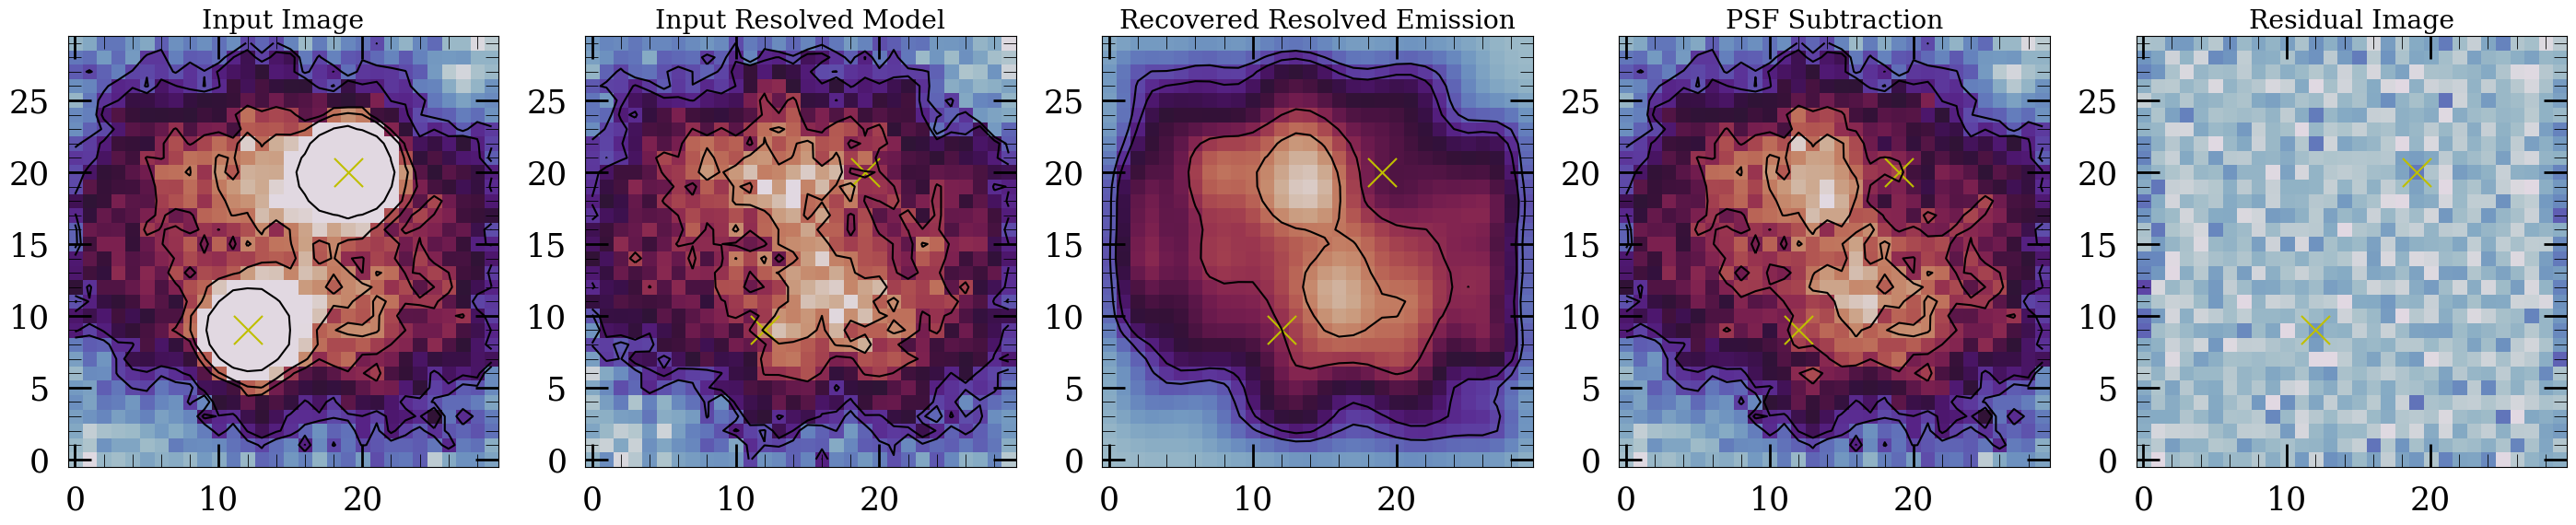

In [13]:
mosaic = np.array([[1,2,3,4,5]])

vmax = 0.32
vmin = -0.04

# Let's plot the results to see how we did...
fig, axes = plt.subplot_mosaic(mosaic,figsize=(35,18))
axes[1].imshow(CC.cube[index[0]],origin='lower',cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[1].contour(CC.cube[index[0]],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
axes[1].scatter(19,20,c='y',marker='x',s=500)
axes[1].scatter(12,9,c='y',marker='x',s=500)
axes[1].set_title('Input Image')

axes[2].imshow(cube_resolved[203],origin='lower',cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[2].contour(cube_resolved[203],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
axes[2].scatter(19,20,c='y',marker='x',s=500)
axes[2].scatter(12,9,c='y',marker='x',s=500)
axes[2].set_title('Input Resolved Model')

axes[3].imshow(CC.resolved[index[0]],origin='lower',cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[3].contour(CC.resolved[index[0]],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
axes[3].scatter(19,20,c='y',marker='x',s=500)
axes[3].scatter(12,9,c='y',marker='x',s=500)
axes[3].set_title('Recovered Resolved Emission')

axes[4].imshow(CC.cube[index[0]]-CC.unresolved[index[0]],origin='lower', cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[4].contour(CC.cube[index[0]]-CC.unresolved[index[0]],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
axes[4].scatter(19,20,c='y',marker='x',s=500)
axes[4].scatter(12,9,c='y',marker='x',s=500)
axes[4].set_title('PSF Subtraction')

axes[5].imshow(CC.cube[index[0]]-CC.unresolved[index[0]]-CC.resolved[index[0]],origin='lower',cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[5].contour(CC.cube[index[0]]-CC.unresolved[index[0]]-CC.resolved[index[0]],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
axes[5].scatter(19,20,c='y',marker='x',s=500)
axes[5].scatter(12,9,c='y',marker='x',s=500)
axes[5].set_title('Residual Image')


plt.show()


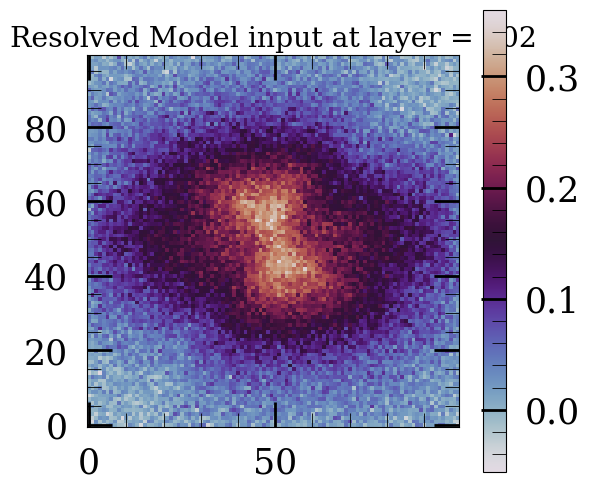

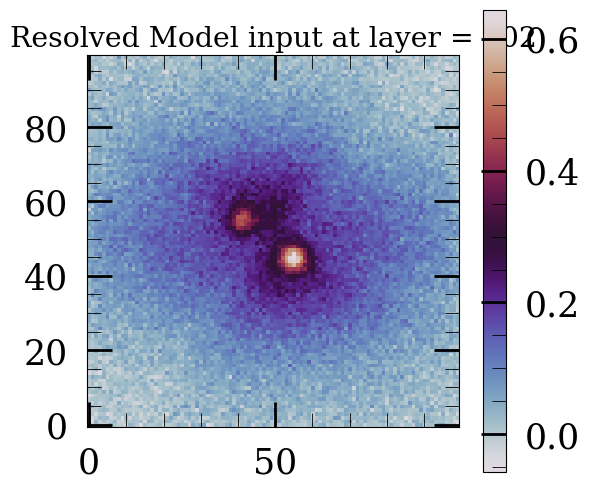

In [23]:

def gaussian(x, mu, sig):
    """
    Calculates the 1D Gaussian probability density function (PDF).
    
    Args:
        x (numpy.array): The x-values at which to evaluate the PDF.
        mu (float): The mean (center) of the distribution.
        sig (float): The standard deviation (width) of the distribution.
        
    Returns:
        numpy.array: The corresponding y-values of the Gaussian curve.
    """
    # The formula for the normal distribution PDF
    return (1.0 / (np.sqrt(2.0 * np.pi) * sig) * 
            np.exp(-np.power((x - mu) / sig, 2.0) / 2))


# -----------------------------
# Image grid
# -----------------------------
nz, ny, nx = 1000, 100, 100
line_mask = gaussian(np.arange(0,nz),200,5)
cube = np.zeros((nz,nx,ny))
cube_resolved = np.zeros((nz,nx,ny))
MEAN = 0.0           # The mean (center) of the noise distribution
STD_DEV = 0.02      # The standard deviation (spread) of the noise
ARRAY_SHAPE = (100, 100) # The desired dimensions (height, width) of the 2D array

# --- Generate the 2D Gaussian noise model ---
# The np.random.normal function takes mean, standard deviation, and shape as inputs.
gaussian_noise_2d = np.random.normal(MEAN, STD_DEV, ARRAY_SHAPE)

for i in range(nz):
    y, x = np.indices((ny, nx))

    # Center of the structure
    x0, y0 = nx // 2, ny // 2

    # Elliptical scaling (controls ellipticity)
    a = 2      # x-axis scaling
    b = 1.0      # y-axis scaling

    # Shifted coordinates
    xp = (x - x0) / a
    yp = (y - y0) / b

    # Elliptical radius and angle
    r = np.sqrt(xp**2 + yp**2)
    theta = np.arctan2(yp, xp)

    # -----------------------------
    # Low-frequency edge modulation
    # -----------------------------
    # Controls the waviness of the ellipse boundary
    wave_amp = 0.2        # strength of the edge perturbation
    wave_mode = 15         # number of lobes (low-frequency)
    r_edge = 50.0          # characteristic radius of the ellipse

    r_mod = r_edge * (1 + wave_amp * np.cos(wave_mode * theta))

    # -----------------------------
    # Radial brightness profile
    # -----------------------------
    # Bright inside, fading outward
    sigma = 18.0
    radial_profile = np.exp(-0.5 * (r / sigma)**2)

    # Soft edge using a logistic transition
    edge_width = 1.0
    edge_mask = 1.0 / (1.0 + np.exp((r - r_mod) / edge_width))

    kernel = Gaussian2DKernel(2.5).array

    # Final image
    image = radial_profile * edge_mask * line_mask[i] * 3

    ##### Cone Emission Add On

    ny, nx = 100, 100
    y, x = np.indices((ny, nx))

    # Center of the image
    x0, y0 = nx // 2, ny // 2
    dx = x - x0
    dy = y - y0

    # -----------------------------
    # Position angle (degrees)
    # -----------------------------
    PA_deg = 104.0            # change this to rotate the cones
    PA = np.deg2rad(PA_deg)

    # Rotate coordinates
    x_rot = dx * np.cos(PA) + dy * np.sin(PA)
    y_rot = -dx * np.sin(PA) + dy * np.cos(PA)

    # -----------------------------
    # Bi-conical geometry
    # -----------------------------
    opening_angle = np.deg2rad(50.0)   # half-opening angle of each cone

    r = np.sqrt(x_rot**2 + y_rot**2)

    # Angle away from cone axis (absolute gives two opposite cones)
    theta = np.arctan2(np.abs(y_rot), np.abs(x_rot))

    # Cone mask
    cone_mask = theta < opening_angle

    # -----------------------------
    # Radial brightness profile
    # -----------------------------
    # Suppress very center + fade outward
    r_inner = 1.0
    r_scale = 30.0

    radial_profile = np.exp(-r / r_scale) * (1.0 - np.exp(-r / r_inner))

    # -----------------------------
    # Soft angular edges
    # -----------------------------
    angular_soft = np.exp(-0.5 * (theta / opening_angle)**4)

    # -----------------------------
    # Final image
    # -----------------------------
    image += cone_mask * radial_profile * angular_soft * line_mask[i] * 2

    # print(np.shape(image))
    # print(np.shape(kernel))
    

    if(i == 202):
        plt.figure(figsize=(6,6))
        plt.title('Resolved Model input at layer = 202')
        plt.imshow(myconvolve(image,kernel) + gaussian_noise_2d, cmap='twilight',origin='lower')
        plt.colorbar()
        plt.show()
    cube_resolved[i] = myconvolve(image,kernel) + gaussian_noise_2d
    image[55,41] += 10
    image[45,55] += 15
    image = myconvolve(image,kernel)
    image += gaussian_noise_2d

    cube[i] = image

    # print(np.max(image))

    
    
# -----------------------------
# Display
# -----------------------------
# plt.figure(figsize=(6, 6))

plt.figure(figsize=(6,6))
plt.title('Resolved Model input at layer = 202')
plt.imshow(cube[203], cmap='twilight',origin='lower')
plt.colorbar()
plt.show()



In [24]:
deactivate = np.array([])
deactivate = np.arange(180,220,1)
pointsources = np.zeros_like(cube[0])
# Declare/Guess the Positions of Point Sources in your Image/Cube
# CubeCarve will build Model PSF based on those positions
pointsources[55,41] = 1 # 29 for 1399-1400
pointsources[45,55] = 1 # 29 for 1399-1400
# image[55,41] += 10
#     image[35,65] += 15

CC = CubeCarve(cube,4,pointsources,xpixelsize=1,ypixelsize=1)

In [25]:
# make psf cube
index = np.array([203])
CC.build_psf_cube(deactivate,200,6,6,index)

Empirical PSF Model(s) Built
Ready to run


In [26]:
CC.run(800,10,sigma=1.5)

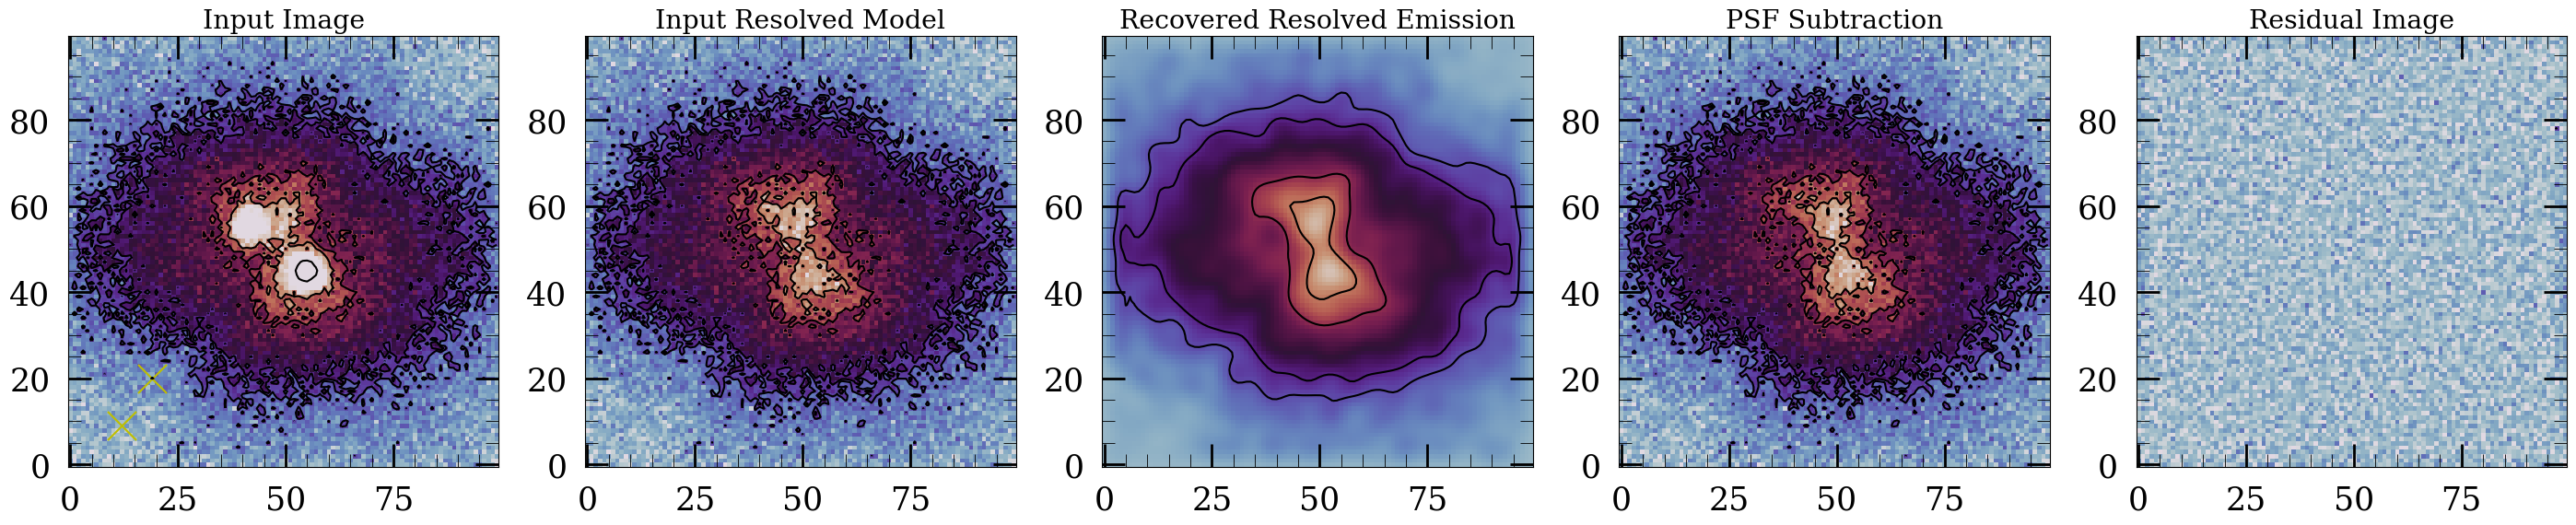

In [27]:
mosaic = np.array([[1,2,3,4,5]])

vmax = 0.32
vmin = -0.04

# Let's plot the results to see how we did...
fig, axes = plt.subplot_mosaic(mosaic,figsize=(35,18))
axes[1].imshow(CC.cube[index[0]],origin='lower',cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[1].contour(CC.cube[index[0]],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
axes[1].scatter(19,20,c='y',marker='x',s=500)
axes[1].scatter(12,9,c='y',marker='x',s=500)
axes[1].set_title('Input Image')

axes[2].imshow(cube_resolved[203],origin='lower',cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[2].contour(cube_resolved[203],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
# axes[2].scatter(19,20,c='y',marker='x',s=500)
# axes[2].scatter(12,9,c='y',marker='x',s=500)
axes[2].set_title('Input Resolved Model')

axes[3].imshow(CC.resolved[index[0]],origin='lower',cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[3].contour(CC.resolved[index[0]],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
# axes[3].scatter(19,20,c='y',marker='x',s=500)
# axes[3].scatter(12,9,c='y',marker='x',s=500)
axes[3].set_title('Recovered Resolved Emission')

axes[4].imshow(CC.cube[index[0]]-CC.unresolved[index[0]],origin='lower', cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[4].contour(CC.cube[index[0]]-CC.unresolved[index[0]],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
# axes[4].scatter(19,20,c='y',marker='x',s=500)
# axes[4].scatter(12,9,c='y',marker='x',s=500)
axes[4].set_title('PSF Subtraction')

axes[5].imshow(CC.cube[index[0]]-CC.unresolved[index[0]]-CC.resolved[index[0]],origin='lower',cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[5].contour(CC.cube[index[0]]-CC.unresolved[index[0]]-CC.resolved[index[0]],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
# axes[5].scatter(19,20,c='y',marker='x',s=500)
# axes[5].scatter(12,9,c='y',marker='x',s=500)
axes[5].set_title('Residual Image')


plt.show()


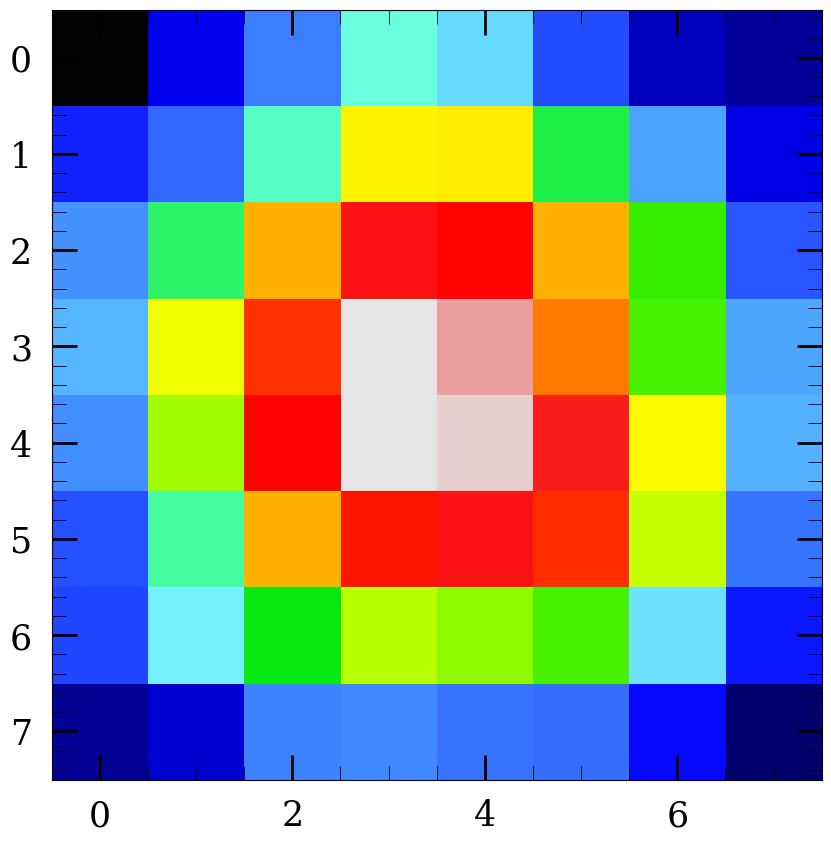

In [25]:
plt.imshow(CC.psf_cube[index[0]])